In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [45]:
df = pd.read_csv('results/trans_results.csv')
perf_df = pd.read_csv('results/perfs.csv')

In [3]:
states = ["s", "d", "b", "f", "q"]
state_names = [s[0].upper() for s in states]

In [40]:
all_sessions = df['session'].unique()
# 28th index session causes problems, omit
all_sessions = np.delete(all_sessions,28)
# filter out MAG
all_sessions = all_sessions[all_sessions < 10000]
all_sessions

array([15203, 15202, 15204, 15201, 16803, 16818, 16810, 16804, 16816,
       16808, 16814, 16815, 16807, 16817, 16806, 16812, 16809, 16813,
       16801, 16819, 16805, 16811, 16802, 96803, 96804, 96815, 96807,
       96817, 96809, 96813, 96805, 96811])

In [13]:
# calculates the transition matrix
# input: a list of transitons
def transition_matrix(transitions):
    trans_list = np.array([])
    n = 5

    for (i,j) in zip(transitions,transitions[1:]):
        mat = np.zeros((n,n))
        mat[i,j] = 1
        trans_list = np.append(trans_list, [mat.flatten()])

    M = sum(trans_list.reshape(int(len(trans_list)/(n**2)), n, n))
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M


In [11]:
# pre-proccesses the transcription BERT results and then computes the transition matrix based off of the results
def trans_wrapper(df, normalized=True):
    transitions = df['labels_h'].copy()
    
    sstates = set(transitions)
    i_t = set(df['labels'].copy())

    # makes sure that there are always 5 possible labels, even if a given session only classifies 4 of them
    not_founds = list(set(range(0,5)) - i_t)

    ids = {k: 0 + i for i, k in enumerate(sstates)}
    transitions = transitions.map(ids)
    

    counts = transitions.value_counts().sort_index()
    frequencies = counts/counts.sum()

    transition = np.array(transition_matrix(transitions))

    f = np.array(frequencies)[None,:]
    f = np.insert(f, 0, not_founds)
    if(normalized):
        transition = transition/f

    return transition

In [42]:
# calculate transition matricies for each session
session_mats = [trans_wrapper(df[df['session'] == session]) for session in all_sessions]


# calculate transition matricies for all sessions
everything_mat = trans_wrapper(df)

In [43]:
# save & export the matricies in a human readable format with labels
columns = []
[[columns.append(ii+jj) for ii in state_names] for jj in state_names]

export_mats_np = np.zeros((len(all_sessions),25))
s_num = 0
for s in session_mats:
    s = s.flatten()
    for ii in range(len(s)-1):
        export_mats_np[s_num,ii] = s[ii]
    s_num += 1
export_mats = pd.DataFrame(export_mats_np,columns=columns)
export_mats.to_csv("results/session_markovs.csv")

In [46]:
# read in normalized performance data
perfs = []
for s in all_sessions:
    if(s in perf_df["mission"].tolist()):
        p = [perf_df[perf_df['mission'] == s]['perf']][0].tolist()
        perfs = perfs + p
perfs = np.array(perfs)

In [48]:
# coerelates transition matrix probability with performance
# for example, if F->F transitions had a probability of .2 for session 1, .3 for session 2 and so on
# and a performance of .1 and .4, corrs would contian the coerealtion coefficient for the F->F transition that relates to performance and 
# pvals would contain the significance of that coerreation coefficient

corrs = np.zeros((len(states), len(states)))
pvals = np.zeros((len(states), len(states)))
markov_df = pd.DataFrame(columns=['from','to','corr','p-val'])
for i in range(0,len(state_names)):
    for j in range(0,len(state_names)):
        l = []
        for m in session_mats:
            try:
                l = l + [m[i][j]]
            except:
                l =l + [0]
        corr, pval = pearsonr(l,perfs)
        corrs[i][j] = corr
        pvals[i][j] = pval
        row = pd.DataFrame({
            "from": states[i],   "to": states[j],
            "corr": corr,       "p-val": pval
        }, index=[len(markov_df.index)])
        markov_df = pd.concat([markov_df, row], ignore_index=True)
markov_df

ValueError: x and y must have the same length.

In [ ]:
# find all transitoins with a p-value greater than .95
sig_trans = pvals > 0.95
markov_df[(sig_trans).flatten()]

,from,to,corr,p-val
8,d,f,0.02631,0.907479


[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'all sessions transition matrix')]

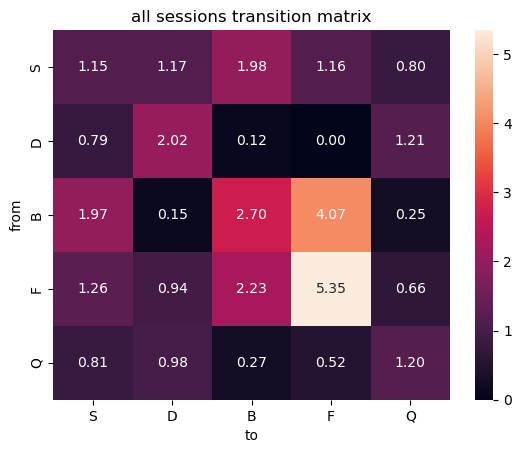

In [ ]:
# trans probabilites matrix for all sessions
hm = sns.heatmap(trans_wrapper(df), fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to', title='all sessions transition matrix')

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'coerrelation matrix')]

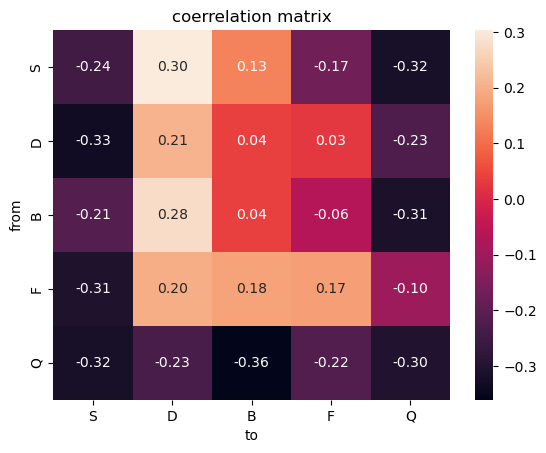

In [ ]:
# coerrelation matrix between transition probabilities and performance 
hm = sns.heatmap(corrs, fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to', title='coerrelation matrix')


In [ ]:
# p-values for above matrix
hm = sns.heatmap(pvals, fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to', title='pvals for coerrelation matrix')

In [ ]:
# calculate the significance of each transition probability in the transition matrix (all sessions)
from scipy.stats import chisquare
chisq, pvalue = chisquare(trans_wrapper(df, normalized=False))

In [ ]:
# high perf defined as normalized performance score >= .5; low performance defined as < .5
high_perfs = [1903,1904,2103,2104,2112,2113,2117]
low_perfs = [1901,1902,2101,2102,2105,2106,2107,2108,2109,21010,2111,2114,2115,2116]

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'high performance transition matrix')]

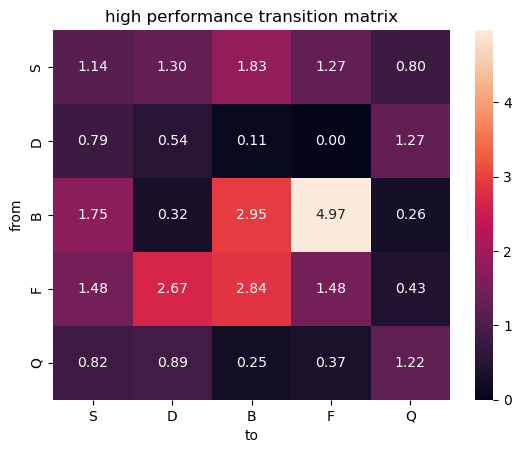

In [ ]:
# transition matrix for high performance sessions
h_df = pd.DataFrame()
for s in high_perfs:
    h_df = pd.concat([df[df['session'] == s],h_df])

hm = sns.heatmap(trans_wrapper(h_df), fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
hm.set(ylabel='from', xlabel='to',title='high performance transition matrix')

[Text(50.722222222222214, 0.5, 'from'),
 Text(0.5, 23.52222222222222, 'to'),
 Text(0.5, 1.0, 'low performance transition matrix')]

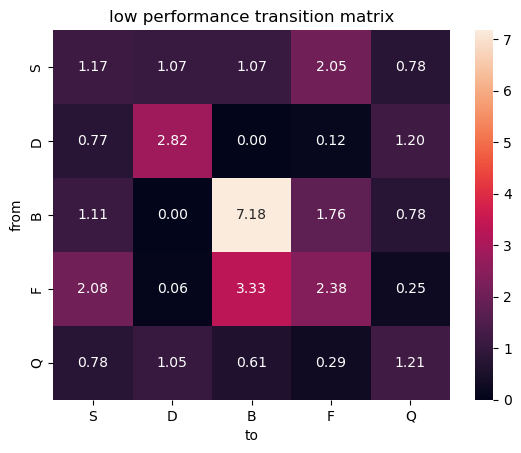

In [ ]:
# low performance transition matrix
l_df = pd.DataFrame()
for s in low_perfs:
    l_df = pd.concat([df[df['session'] == s],l_df])

lm = sns.heatmap(trans_wrapper(l_df), fmt='.2f',annot=True, xticklabels=(state_names), yticklabels=(state_names))
lm.set(ylabel='from', xlabel='to',title='low performance transition matrix')

heatmaps(nek21_trans_df['labels_h'].copy(), title="trans")